In [1]:
#%env https_proxy http://iss-emea-pitc-amsterdamz.proxy.corporate.ge.com:80

In [2]:
# update data
!rm -rf COVID-19
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 16878 (delta 0), reused 2 (delta 0), pack-reused 16872
Receiving objects: 100% (16878/16878), 65.60 MiB | 749.00 KiB/s, done.
Resolving deltas: 100% (8431/8431), done.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [5]:
df[(df['Country/Region']=='US') & ((df['Province/State'].isna()) | (df['Province/State']=='US'))]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,19100,25489,33276,43847,53740,65778,83836,101657,121478,140886


In [6]:
def __split_data(df, nation):

    idx_start = 4

    df_n = df[(df['Country/Region']==nation) & ((df['Province/State'].isna()) | (df['Province/State']==nation))]
    
    n = df_n.shape[0]
    
    X = []
    y = []
    
    for i in range(0,n):
    
        X_t = np.asarray([datetime.strptime(col, '%m/%d/%y').timestamp() for col in df.columns[idx_start:]])
        y_t = df_n.values[i][idx_start:]

        idx = 0
        ii = [ i for i,y in enumerate(y_t) if y<100]
        if len(ii)>0:
            idx = max( ii )

        X_t = X_t[idx:]
        y_t = y_t[idx:]
        
        first_day = min(X_t)

        # renoramlize
        SEC_PER_DAY=24*60*60
        X_t = np.asarray([ (x - first_day)/SEC_PER_DAY for x in X_t])
      
        
        X.append(X_t)
        y.append(y_t)

    return np.asarray(X), np.asarray(y), df_n['Province/State'].values

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

def __build_model(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                      ('linear', ElasticNet(fit_intercept=False, max_iter=10000,normalize=True, warm_start=True))])

    return model

def __evaluate_model(X_train, y_train, model):
      
    # predicting on training data-set
    y_train_predicted = model.predict(X_train)
    
    
    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
    mape = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100


    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("MAPE score of training set is {}".format(mape))

    return mape, rmse_train, r2_train

In [8]:
def predict_and_plot(df, nation, population, next_days, color, model_l, model_u):
    
    DEGREE=4

    X_train_l, y_train_l, provinces = __split_data(df, nation)

    n = X_train_l.shape[0]
    

    for i, p in enumerate(provinces):
        
        X_train = X_train_l[i] 
        y_train = y_train_l[i]
        
        X_train =X_train[1:]
        y_train = y_train[1:] - y_train[0:-1]
        
        #normalize
        y_train = y_train / population

        last_day = max(X_train)
        
        if str(p)=='nan':
            p='all'
        else:
            p = str(p)
        
        
        X_test = np.asarray([ i +last_day for i in range(0,next_days)])
        if not(model_l):
            model_l = __build_model(DEGREE)
        model_l.fit(X_train.reshape(-1, 1)  , y_train )
        y_test_predict_u = model_l.predict(X_test.reshape(-1, 1))
        
        if not(model_u):
            model_u = __build_model(DEGREE+1)
        model_u.fit(X_train.reshape(-1, 1) , y_train)
        y_test_predict_l = model_u.predict(X_test.reshape(-1, 1))
        
        y_test_predict = y_test_predict_u/2 + y_test_predict_l/2
        
        #y_test_predict_l, y_test_predict_u = y_test_predict - y_test_predict*mape/200, y_test_predict + y_test_predict*mape/200
        
        # show predicted data * population
        plt.plot(X_train, y_train * population, label=nation + ' ' + p + ' actual',c=color, linewidth=3.0)
        plt.plot(X_test, y_test_predict * population,':',c=color, linewidth=3.0)
        plt.fill_between(X_test, y_test_predict_l* population, y_test_predict_u* population, color=color, alpha=0.3, label= nation + ' predicted')
        
        print('current day ', X_train[-1], nation, p,":", y_test_predict[0] * population, y_train[-1])
        print('next day ', X_test[1], nation, p,":", y_test_predict[1]* population)
        
        return model_l, model_u

In [9]:
population_by_nation = {'Italy': 60.480,
                        'France': 66.890,
                        'Spain':46.600,
                         'Japan':126.800,
                         'Germany': 82.790,
                         'Norway': 5.368,
                         'Belgium': 11.400,
                         'Greece': 10.740,
                        'US':331.002651}
population_by_nation = {'Italy': 60.480,'France': 66.890,'Germany': 82.790,'Spain':46.600, 'US':331.002651}

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2512.0593412886624, tolerance: 12.587156337264847
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2535.3988368699656, tolerance: 12.587156337264847
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 894.5043530138778, tolerance: 2.4645485239934337
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

current day  36.0 Italy all : 5308.617738253342 86.25992063492063
next day  37.0 Italy all : 4886.438873598178
current day  30.0 France all : 3688.3626395036513 38.85483629840036
next day  31.0 France all : 3685.8776135238672
current day  29.0 Germany all : 5940.441034554857 53.14651527962314
next day  30.0 Germany all : 5947.533323111699
current day  28.0 Spain all : 7800.042440646182 147.5321888412017
next day  29.0 Spain all : 7597.825582427342
current day  27.0 US all : 20637.71712413275 58.63397148441569
next day  28.0 US all : 22022.716721912162


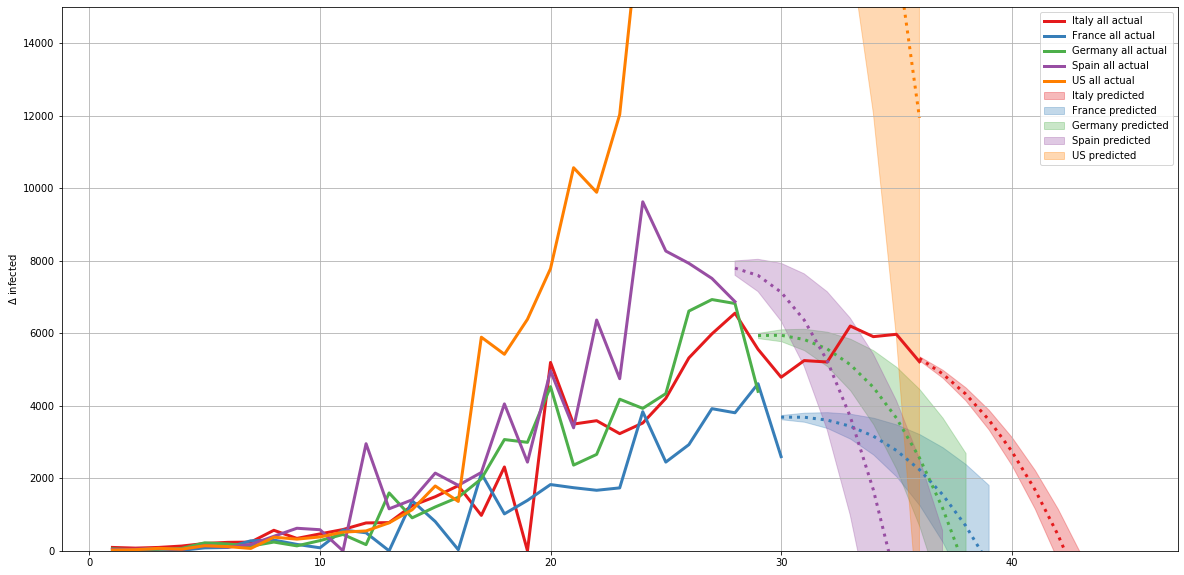

In [13]:
from matplotlib.cm import get_cmap

name = "Set1"
cmap = get_cmap(name)
COLORS =  cmap.colors


def predict_and_plot_all(df, population_by_nation, next_days):
    model_l, model_u = None, None
    plt.figure(figsize=(20,10))
    for i,nation in enumerate(population_by_nation):
        #print("--\n",nation)
        population = population_by_nation[nation]
        model_l, model_u = predict_and_plot(df, nation,population, next_days, color = COLORS[i], model_l=model_l, model_u=model_u)
    
    plt.ylim(0, 15000)
    plt.ylabel('$\Delta$ infected')
    plt.legend()
    plt.grid()
    plt.show()
    
predict_and_plot_all(df, population_by_nation, 10)